## Notebook & API Setup

In [1]:
# import packages
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import pandas as pd
from datetime import timedelta
pd.set_option("display.max.columns", None)
import requests
import json
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# Functions to get API data -> .json

In [2]:
def request_access_token(client_id, client_secret, refresh_token):
    auth_url_mask = "https://www.strava.com/oauth/token" # authorization url mask
    payload = {
        'client_id': client_id,
        'client_secret': client_secret,
        'refresh_token': refresh_token,
        'grant_type': "refresh_token",
        'f': 'json'
    }
    print("Requesting Token...\n")
    res = requests.post(auth_url_mask, data=payload, verify=False)
    access_token = res.json()['access_token']
    print("Access Token = {}\n".format(access_token))
    return access_token

def filter_to_cycling_with_stream_data(activity_df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters a dataframe of strava activities to only include cycling activities which contain power and/or heart rate data. 
    Returns a new dataframe.
    """
    df = activity_df[(activity_df['type'].isin(['Ride', 'VirtualRide']))].copy() # cycling activities only

    # clean up boolean power data column
    df['device_watts'] = pd.to_numeric(df['device_watts'], errors='coerce')
    df['device_watts'].fillna(False, inplace=True)
    df['device_watts'] = df['device_watts'].astype(bool)

    # clean up boolean heart rate data column
    df['has_heartrate'] = pd.to_numeric(df['has_heartrate'], errors='coerce')
    df['has_heartrate'].fillna(False, inplace=True)
    df['has_heartrate'] = df['has_heartrate'].astype(bool)
    
    # apply filter
    df = df[df['device_watts'] | df['has_heartrate']].copy()
    return df

def get_new_rides(access_token:str, file_name:str = 'strava_data.json'):
    """
    Fetches new rides from Strava using user's url and access token.
    """
    activities_url = "https://www.strava.com/api/v3/athlete/activities" # activities url mask
    header = {'Authorization': 'Bearer ' + access_token}

    request_page_num = 1
    activities_byPage = []
    print('retrieving activity data...')
    
    while True:
        # fetches data from api; limited to 200 activities per request -- must retrieve by page
        param = {'per_page': 200, 'page': request_page_num}
        page_data = []
        page_data = requests.get(activities_url, headers=header, params=param).json()

        if type(page_data) == dict: # page_data is a dict if the api limit has been exceeded
            # break loop and alert user
            print('Error: rate limit exceeded')
            break
        if len(page_data) == 0: # check to make sure the list is not empty
            # break loop and alert user
            print("retrieved all activities :)")
            break
        else:
            # build list of activities from pages
            activities_byPage.append(page_data)
            print('retrieved ' + str(len(page_data)) + ' activities from page ' + str(request_page_num))
        request_page_num += 1

    if ((type(page_data) == dict) & (len(activities_byPage) == 0)): # checks if page_data is a dict and there are no new activities to append
            print('exiting...')
    
    all_activities = [item for sublist in activities_byPage for item in sublist] # un-nests activities from pages
    all_activities_df = pd.DataFrame(all_activities) # converts list to df
    all_rides_df = filter_to_cycling_with_stream_data(all_activities_df) # filters to cycling activities with stream data

    try: # append only new activities so as not to overwrite existing data
        existing_rides_df = pd.read_json(file_name, orient='records') # retrieves existing data from local file
        new_ride_ids = list(set(all_rides_df['id'].values) - set(existing_rides_df['id'].values)) # retrieves IDs from new rides
        new_rides_df = all_rides_df[all_rides_df['id'].isin(new_ride_ids)] # creates df of new rides
        ride_df = pd.concat([new_rides_df, existing_rides_df]) # appends new and existing rides
        print(str(len(new_rides_df)) + ' new rides appended \n')
    except FileNotFoundError:
        ride_df = all_rides_df.copy() # saves all loaded rides to new local file
        print('could not find existing file - new file created')
        print(str(len(ride_df)) + ' rides saved \n')
    ride_df.to_json(file_name, orient='records') # write to .json

def get_new_rides_stream_data(access_token:str, file_name:str = 'strava_data.json'):
    """
    Gets details for power, heart rate, cadence and time data for each ride.
    """
    header = {'Authorization': 'Bearer ' + access_token}
    
    ride_df = pd.read_json('strava_data.json', orient='records')
    metrics = ['watts', 'cadence', 'heartrate', 'time']
    for metric in metrics: # adds metric column to the ride_df if it doesn't already exist
        if f'{metric}Stream' not in ride_df.columns:
            ride_df[f'{metric}Stream'] = None
            print(f'added {metric}Stream column')

    count = 0
    stream_data = []
    print('retrieving stream data...')
    for i, row in ride_df.iterrows(): # iterate over rows of ride_df
        for metric in metrics: # iterate over stream columns (by row)
            if ride_df.at[i, f'{metric}Stream'] == None: # checks if cell is empty

                stream_params = {'keys': {metric}, 'key_by_type': 'true'} # define parameters for request

                # request stream data
                stream_url = f"https://www.strava.com/api/v3/activities/{row['id']}/streams"
                stream_data = requests.get(stream_url, headers=header, params=stream_params).json()
                print(stream_data)
                if stream_data.get('message', 'OK') == 'Rate Limit Exceeded':
                    print('Error: rate limit exceeded')
                    break
                if stream_data == []:
                    print('empty list, skipping')
                    ride_df.at[i, f'{metric}Stream'] = 'n/a'
                    continue
                # assign power data to the appropriate ride in the DataFrame
                try:
                    ride_df.at[i, f'{metric}Stream'] = stream_data[f'{metric}']['data']
                    count += 1
                except KeyError:
                    ride_df.at[i, f'{metric}Stream'] = 'n/a'
            else: continue # skip cells with data
        if type(stream_data) == dict:
            if stream_data.get('message', 'OK') == 'Rate Limit Exceeded':
                print('exiting...')
                break

    if count > 0:
        ride_df.to_json(file_name, orient='records')
        print(str(count) + ' cells updated with stream data :)')
        ride_df.head()
    else:
        print('no new data to retrieve')

# Update Data

In [3]:
# run this cell to update .json file with new data from the Strava API
user_client_id = "116573"
user_client_secret = 'f178359239fbb2c061697c8163a874471ca263de'
user_refresh_token = 'c00d945cd19b4238d9bdb9a5ebfcc1cff48ec05a'
access_token = request_access_token(user_client_id, user_client_secret, user_refresh_token)
file_name = 'strava_data.json'

get_new_rides(access_token)
get_new_rides_stream_data(access_token)

Requesting Token...

Access Token = 127b3ac98fb5737cfe6241685dd55805a4c93d6e

retrieving activity data...
retrieved 200 activities from page 1
retrieved 200 activities from page 2
retrieved 101 activities from page 3
retrieved all activities :)
0 new rides appended 

retrieving stream data...
no new data to retrieve


# Data Wrangling

In [4]:
# load data from .json file to df
df = pd.read_json('strava_data.json', orient='records')

# drop useless columns
df.dropna(axis=1, how='all', inplace=True)
df.drop(['resource_state', 
         'athlete', 
         'utc_offset', 
         'start_date',
         'photo_count', 
         'manual', 
         'private', 
         'flagged', 
         'weighted_average_watts', 
         'device_watts', 
         'has_heartrate',
         'heartrate_opt_out', 
         'display_hide_heartrate_option', 
         'upload_id', 
         'upload_id_str', 
         'external_id', 
         'from_accepted_tag', 
         'has_kudoed', 
         'total_photo_count', 
         'workout_type'], 
        axis=1, inplace=True)

# conversion constants
feet_in_meter = 3.28084
feet_in_mile = 5280
metersPerSec_to_mph = 2.23694

# convert to American units
df['distance'] = round(df['distance'] * feet_in_meter / feet_in_mile, ndigits=2)
df['average_speed'] = round(df['average_speed'] * metersPerSec_to_mph, ndigits=2)
df['max_speed'] = round(df['max_speed'] * metersPerSec_to_mph, ndigits=2)
df['total_elevation_gain'] = round(df['total_elevation_gain'] * feet_in_meter, ndigits=2)
df['elev_high'] = round(df['elev_high'] * feet_in_meter, ndigits=2)
df['elev_low'] = round(df['elev_low'] * feet_in_meter, ndigits=2)
df['average_temp'] = (df['average_temp'] * (9/5)) + 32

# convert dates to datetime/timedeltas
df['start_date_local'] = pd.to_datetime(df['start_date_local'].str.replace('T', ' ').str.replace('Z', ''))
df['moving_time'] = pd.to_timedelta(df['moving_time'], unit='s')
df['elapsed_time'] = pd.to_timedelta(df['elapsed_time'], unit='s')

# gets the location from the timezone field since its not listed anywhere else
def location_from_timezone(timezone):
    # extract the part after ')'
    location = timezone.split(')')[-1] if ')' in timezone else timezone

    # split the location by '/' and join by ', '
    location_parts = location.split('/')
    location_parts = reversed(location_parts)
    formatted_location = ', '.join(location_parts)

    return formatted_location
df['timezone'] = df['timezone'].apply(location_from_timezone)

# extracts the useful part of the polyline field which can be decoded (via a package) into a long list of coordinates
def extract_polyline(map_col):
    polyline = map_col['summary_polyline']
    return polyline
df['map'] = df['map'].apply(extract_polyline)

# fills empty list items with 0 (so standard of deviation calculation wont throw an error)
def fill_none_with_zero(input_list):
    if input_list == 'n/a':
        return 'n/a'
    else:
        return [0 if item is None else item for item in input_list]

# apply above function to stream data
df['wattsStream'] = df['wattsStream'].apply(fill_none_with_zero)
df['cadenceStream'] = df['cadenceStream'].apply(fill_none_with_zero)
df['heartrateStream'] = df['heartrateStream'].apply(fill_none_with_zero)
df['timeStream'] = df['timeStream'].apply(fill_none_with_zero)

# calculates the standard deviation of the items of a list
def calculate_std(data_list):
    if data_list == 'n/a':
        return 'n/a'
    else:
        try:
            std = round(np.std(data_list, ddof=1), 1)
        except:
            std = 'n/a'
        return std
df['power_std'] = df['wattsStream'].apply(calculate_std)

df = df.rename(columns={'timezone': 'location', 'map': 'map_polyline'})         
df.sort_values(by='start_date_local', ascending=False, inplace=True)
df['id'] = range(len(df['id']), 0, -1) # create simpler id column
df.set_index('id', inplace=True) # sets my id as the index
print('num rides: ' + str(len(df)))
df.head()

num rides: 285


,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,start_date_local,location,achievement_count,kudos_count,comment_count,athlete_count,map_polyline,trainer,commute,visibility,gear_id,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_watts,max_watts,kilojoules,average_heartrate,max_heartrate,elev_high,elev_low,pr_count,suffer_score,average_temp,wattsStream,cadenceStream,heartrateStream,timeStream,power_std
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
285,Zwift - Pacer Group Ride: Flat Route in Watopi...,24.50,0 days 01:05:01,0 days 01:05:23,771.00,VirtualRide,VirtualRide,2024-01-21 09:42:00,"Indianapolis, Indiana, America",5,1,0,23,|~afAia_z^Bd@r@\`KoAtALcAn@cM`BXn@bISvD~@^rD`C...,False,False,everyone,b12736344,"[-11.6479861736, 166.9533383846]","[-11.6536965966, 166.9559562206]",22.61,39.10,99.8,189.3,1034.0,738.4,163.0,200.0,75.46,-20.34,2,109.0,NaN,"[366, 343, 271, 325, 251, 182, 153, 186, 192, ...","[105, 114, 116, 109, 111, 113, 113, 107, 107, ...","[121, 120, 118, 117, 116, 115, 115, 114, 115, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",106.7
284,Zwift - Pacer Group Ride: Castle to Castle in ...,25.25,0 days 01:08:37,0 days 01:08:37,892.39,VirtualRide,VirtualRide,2024-01-20 17:47:18,"Indianapolis, Indiana, America",4,2,0,7,tbw`Asucs^zD_@vIvAfImAjEyIrI_DtBkEw@yDdC_B~A}E...,False,False,everyone,b12736344,"[-10.7730636746, 165.8301901817]","[-10.7625822723, 165.8458006382]",22.08,38.17,99.5,197.9,1186.0,814.7,156.9,192.0,459.97,204.72,2,91.0,NaN,"[65, 71, 81, 60, 46, 62, 62, 61, 53, 51, 60, 7...","[86, 84, 85, 86, 88, 88, 90, 91, 92, 92, 93, 9...","[101, 101, 101, 102, 103, 104, 104, 105, 104, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",85.3
283,Zwift - VO2 Pyramid in Richmond,17.33,0 days 00:46:35,0 days 00:47:04,370.73,VirtualRide,VirtualRide,2024-01-19 15:34:02,"Indianapolis, Indiana, America",6,2,0,2,{lddFxvuwMELq@rAC?eM|VgDlGgB|DgAnBwCzFOTo@TSPE...,False,False,everyone,b12736344,"[37.5471818447, -77.4489301443]","[37.5559365749, -77.4638754129]",22.32,33.08,102.6,211.0,478.0,589.8,160.5,192.0,211.94,169.29,2,77.0,NaN,"[169, 155, 97, 97, 104, 120, 57, 83, 94, 86, 1...","[53, 72, 87, 89, 89, 93, 93, 90, 87, 85, 82, 8...","[81, 81, 81, 80, 79, 79, 80, 80, 81, 82, 84, 8...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",86.9
282,Zwift - Endurance /Free Ride in Makuri Islands,2.46,0 days 00:17:06,0 days 00:17:21,360.89,VirtualRide,VirtualRide,2024-01-18 15:47:31,"Indianapolis, Indiana, America",2,2,0,4,pkq`Asyhs^^S\OZIF?v@[PS`@m@TQNGZGxAAFCz@IXKj@?...,False,False,everyone,b11959294,"[-10.7437605411, 165.8564221859]","[-10.7594025135, 165.8546626568]",8.63,18.56,77.0,117.4,260.0,120.5,148.5,165.0,732.94,398.95,0,14.0,NaN,"[62, 57, 57, 69, 100, 121, 127, 125, 121, 113,...","[85, 83, 82, 80, 79, 78, 79, 80, 80, 80, 80, 8...","[153, 152, 151, 150, 150, 150, 151, 152, 154, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",43.3
281,Zwift,11.10,0 days 00:31:38,0 days 00:35:10,492.13,VirtualRide,VirtualRide,2024-01-18 15:11:24,"Indianapolis, Indiana, America",0,2,0,37,|x_fA_wbz^{@u@gC_@[U]y@cBcGK}@t@kEB{@YcAuA{BGa...,False,False,everyone,b11959294,"[-11.6367839277, 166.9721674919]","[-11.6428993642, 166.9728541374]",21.06,37.76,95.6,207.9,325.0,394.6,159.1,202.0,271.00,41.34,0,59.0,NaN,"[28, 5, 0, 0, 0, 22, 37, 70, 130, 159, 144, 11...","[59, 58, 59, 59, 59, 1, 7, 19, 2, 43, 55, 70, ...","[98, 96, 95, 93, 92, 95, 95, 97, 99, 100, 101,...","[0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 30, 31, 32...",78.9


## Analysis

In [5]:
print('total rides in dataset: ' + str(len(df)))
print('total distance covered: ' + str(df['distance'].sum()) + ' miles')
print('total moving time: ' + str(df['moving_time'].sum()))
print('overall average speed: ' + str(round(df['average_speed'].mean(), 1)) + ' mph')
print('overall average speed (derived): ' + str(round(df['distance'].sum() / (df['moving_time'].sum().total_seconds()/60/60), 1)) + ' mph')
print('total elevation gain: ' + str(df['total_elevation_gain'].sum()) + ' ft')
print('overall average suffer score: ' + str(round(df['suffer_score'].mean())))
print('overall average cadence: ' + str(round(df['average_cadence'].mean())) + ' rpm')
print('overall average power: ' + str(round(df['average_watts'].mean())) + ' watts')
print('overall average heartrate: ' + str(round(df['average_heartrate'].mean())) + ' bpm')

total rides in dataset: 285
total distance covered: 7010.360000000001 miles
total moving time: 17 days 16:59:21
overall average speed: 16.2 mph
overall average speed (derived): 16.5 mph
total elevation gain: 302140.98 ft
overall average suffer score: 99
overall average cadence: 84 rpm
overall average power: 165 watts
overall average heartrate: 146 bpm


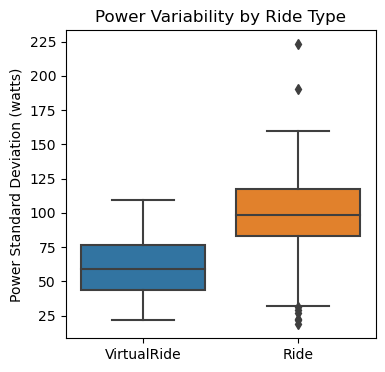

In [6]:
# power variability by ride type
df2 = df[df['power_std']!='n/a'].copy()
plt.figure(figsize=(4, 4))
sns.boxplot(x=df2['type'], y=df2['power_std'])
plt.title('Power Variability by Ride Type')
plt.ylabel('Power Standard Deviation (watts)')
plt.xlabel('')
plt.show()

In [7]:
display(df[['name', 'suffer_score']].loc[df['suffer_score'].idxmax()]) # hardest ride
display(df[['name', 'distance']].loc[df['distance'].idxmax()]) # longest ride
df_outdoor = df[df['type']=='Ride'].copy()
display(df_outdoor[['name', 'average_speed']].loc[df_outdoor['average_speed'].idxmax()]) # fastest outdoor ride
display(df[['name', 'total_elevation_gain']].loc[df['total_elevation_gain'].idxmax()]) # greatest elevation gain

name            Califlorida
suffer_score          453.0
Name: 257, dtype: object

name        RAIN 2023 🤩🌧️
distance           161.95
Name: 138, dtype: object

name             Practice Race
average_speed            25.26
Name: 90, dtype: object

name                    Griffy 10k 🚀
total_elevation_gain        10367.45
Name: 182, dtype: object

# Dashboard Setup

In [8]:
# Create a tuple of ride names and their corresponding indices
ride_index_zip = tuple([name, index] for name, index in zip(df['name'], df.index))

# Define lists and dictionaries for chart-related information
ride_metrics = ['watts', 'cadence', 'heartrate']
ride_metrics_colors = {'watts': '#4B0082', 'cadence': '#8A0A8A', 'heartrate': 'red'}
ride_metrics_names = {'watts': 'Power', 'cadence': 'Cadence', 'heartrate': 'Heart Rate'}
ride_metrics_units = {'watts': 'watts', 'cadence': 'rpm', 'heartrate': 'bpm'}

# Define time units
time_units = ['seconds', 'minutes']

# Create a dropdown widget to select a ride from its name and return its index
ride_picker = widgets.Dropdown(
    placeholder='Choose a Ride',
    options=ride_index_zip,
    description='Ride Name:',
    ensure_option=True,
    disabled=False
)

# Create a dropdown widget to choose a metric for analysis
metric_picker = widgets.Dropdown(
    placeholder='Choose a Metric',
    options=ride_metrics,
    value='watts',
    description='Metric:',
    ensure_option=True,
    disabled=False
)

# Create a multi-select widget to choose columns to display
column_picker = widgets.SelectMultiple(
    options=df.columns,
    rows=10,
    value=tuple(['name', 'distance', 'moving_time', 'total_elevation_gain', 'average_speed', 'suffer_score']),
    description='Columns:',
    disabled=False
)

# Create a dropdown widget to choose time units for duration slider
time_unit_picker = widgets.Dropdown(
    placeholder='Select Time Unit',
    options=time_units,
    value='seconds',
    description='Time Unit:',
    ensure_option=True,
    disabled=False
)

# Create an integer slider to choose the duration for max average power analysis
duration_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=60,
    step=1,
    description='Duration:',
    orientation='horizontal',
    continuous_update=True
)

# Define a function to normalize metric values based on time values
def normalize_metric(time_values, metric_values):
    # Create a sequence from min to max of time
    time_norm = list(range(min(time_values), max(time_values) + 1))

    # Create an array of zeros with the same length as the normalized time
    metric_norm = [0] * len(time_norm)

    # Map the values from the original metric array
    for i, val in enumerate(time_values):
        index = time_norm.index(val)
        if metric_values[i] == None:
            metric_norm[index] = 0
        else:
            metric_norm[index] = metric_values[i]

    return time_norm, metric_norm

# Define a function to find the highest x consecutive seconds of the metric in the ride
def find_peak(duration_sec, time_values, metric_values):
    # Normalize power values to account for pauses
    time_norm, metric_norm = normalize_metric(time_values, metric_values)
    
    n = len(metric_norm)
    t = duration_sec
    
    # Ensure there is enough data
    if n < t:
        return "Not enough data" if n > 0 else None

    # Initialize maximum power peak
    max_peak = sum(metric_norm[0:t]) / t

    # Iterate over power_norm with a window size of duration_sec
    for i in range(n - t + 1):
        # Calculate the average of the current window
        current_peak = sum(metric_norm[i:i + t]) / t

        # Update the maximum average if the current is greater
        if current_peak > max_peak:
            max_peak = current_peak

    return max_peak

# Define a function to output selected columns and their values
def return_stats(index, columns):
    col_to_hide = [col for col in df.columns if col not in list(columns)]
    df_skinny = df.drop(col_to_hide, axis=1)
    print(df_skinny.loc[int(index)].to_string())

# Define a function to convert time in seconds to a datetime time delta (duration)
def time_to_duration(time_list):
    durations = []
    for index, t in enumerate(time_list):
        durations.append(timedelta(seconds=t))
    return durations

# Define a function to generate x-axis time labels for charts
def generate_time_ticks(time_list):
    interval_duration_sec = max(time_list) / 10
    interval_duration = round((interval_duration_sec) / 300) * 300
    if interval_duration == 0:
        interval_duration = 300
    xtick_marks = []
    num_marks = round(max(time_list) / interval_duration)
    for marks in range(0, num_marks):
        xtick_marks.append(interval_duration * marks)
    xtick_marks.append(max(time_list))
    return xtick_marks

# Define a function to output a chart based on the selected ride and metric    
def return_charts(index, metric): 
    time = df.loc[index]['timeStream']
    time_ticks = generate_time_ticks(time)
    durations = time_to_duration(time_ticks)
    durations_str = list(map(str, durations))
    metric_stream = df.loc[index][f'{metric}Stream']
    if metric_stream == 'n/a':
        print(f'Missing {metric} stream data')
    else:
        plt.figure(figsize=(10, 4))
        sns.lineplot(x=time, y=metric_stream, color=ride_metrics_colors[f'{metric}'])
        plt.title(str(ride_metrics_names[f'{metric}']) + f' - {df["name"].loc[index]}')
        plt.xlabel('Time')
        plt.ylabel(str(ride_metrics_names[f'{metric}']) + ' (' + str(ride_metrics_units[f'{metric}']) + ')')
        plt.xticks(ticks=time_ticks, labels=durations_str, rotation=75)
        plt.show()

# Define formatting for displaying the selected metric peak
def return_peak(index, metric, duration, unit):
    metric_stream = df[f'{metric}Stream'].loc[index]
    time_stream = df['timeStream'].loc[index]
    try:
        if unit == 'seconds':
            print('Max average power for selected duration: ' + str(round(find_peak(duration, time_stream, metric_stream))) + ' ' + str(ride_metrics_units[f'{metric}']))
        elif unit == 'minutes':
            print('Max average power for selected duration: ' + str(round(find_peak(duration * 60, time_stream, metric_stream))) + ' ' + str(ride_metrics_units[f'{metric}']))
    except TypeError:
        print('Choose a shorter duration')
    except IndexError:
        print(f'Missing {metric} stream data')

# Define comparison of this ride's average x metric to the overall average of the dataset
def return_charts2(index, metric): 
    try:
        total_avg_metric = df[f'average_{metric}'].mean()
        avg_metric = sum(df.loc[index][f'{metric}Stream']) / len(df.loc[index][f'{metric}Stream'])
        if avg_metric >= total_avg_metric:
            this_ride_color = 'green'
        else:
            this_ride_color = 'red'

        values = [total_avg_metric, avg_metric]
        labels = [f'All-Time Average {metric}', f'This Ride\'s Average {metric}']
        plt.figure(figsize=(6, 3))
        bars = plt.bar(labels, values, color=[ride_metrics_colors[metric], this_ride_color])
        plt.ylabel(str(ride_metrics_names[f'{metric}']) + ' (' + str(ride_metrics_units[f'{metric}']) + ')')
        
        for bar in bars:
            yval = bar.get_height() - 20
            plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

        plt.show()
    except TypeError:
        print(f'Missing {metric} stream data')

# Define a function to show the suffer score trend
def return_charts3(index):
    try:
        previous_indexes = range(10, -1, -1)
        values = []
        labels = []
        for i in previous_indexes:
            values.append(df.loc[index - i]['suffer_score'])
            labels.append(str(i))
        labels[len(labels) - 1] = 'This Ride'
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=labels, y=values, color='red')
        plt.xticks(ticks=labels, labels=labels)
        plt.title('Suffer Score Trend')
        plt.xlabel('Previous 10 Rides')
        plt.ylabel('Suffer Score')
        plt.show()
    except KeyError:
        print('Missing suffer score data')

# Set widget sizes
ride_picker.layout.width = '400px'
ride_picker.layout.height = '30px'
duration_slider.layout.width = '750px'
duration_slider.layout.height = '30px'

# Create a divider
divider = widgets.HTML('<hr>')

# Create interactive outputs for widgets
out = widgets.interactive_output(return_stats, {'index': ride_picker, 'columns': column_picker})
out_charts = widgets.interactive_output(return_charts, {'index': ride_picker, 'metric': metric_picker})
out_charts2 = widgets.interactive_output(return_charts2, {'index': ride_picker, 'metric': metric_picker})
out_charts3 = widgets.interactive_output(return_charts3, {'index': ride_picker})
out_peaks = widgets.interactive_output(return_peak, {'index': ride_picker, 'duration': duration_slider, 'unit': time_unit_picker, 'metric': metric_picker})


# Dashboard

In [9]:
display(widgets.HBox([
    widgets.VBox([ride_picker, 
                  column_picker,
                  out,
                  divider,
                  divider,
                  out_charts3]),
    widgets.VBox([metric_picker,
                  out_charts,
                  out_charts2,
                  divider,
                  time_unit_picker,
                  duration_slider,
                  out_peaks,
                  divider
                  ])
]))